In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from iit_tpm import make_tpm, tpm_series, serie_plot, tpm_syn
from grn_tpm import iit_tpm_cal


bnet = {
    ('B', "C", 'A'): 'bc_a',

    ('E1', 'E2', 'A'): '12_a'

}

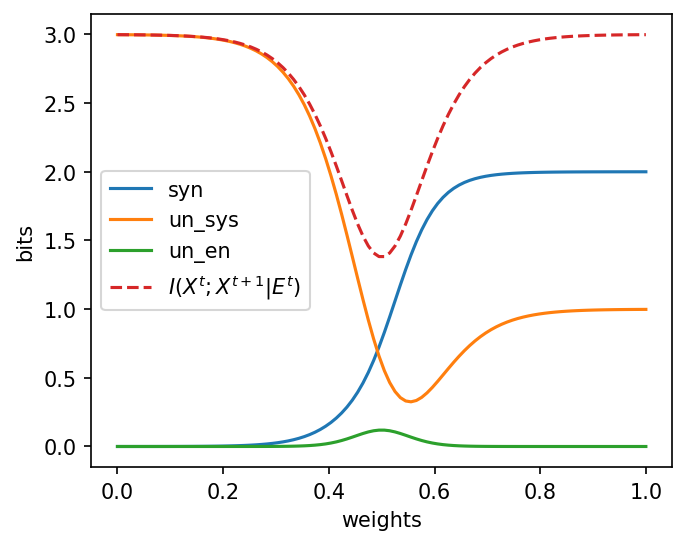

In [41]:
syn_list = []
un_sys_list = []
un_en_list = []
condi_list = []
w_axis = np.linspace(0, 1, 100)
for w in w_axis:
    
    tpm_v = tpm_syn(k=10, w=w)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    condi_list.append(un_sys+syn)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(w_axis, syn_list, label='syn')
plt.plot(w_axis, un_sys_list, label="un_sys")
plt.plot(w_axis, un_en_list, label="un_en")
plt.plot(w_axis, condi_list, linestyle='--', label=r"$I(X^t;X^{t+1}|E^t)$")
plt.xlabel('weights')
plt.ylabel('bits')
plt.legend()

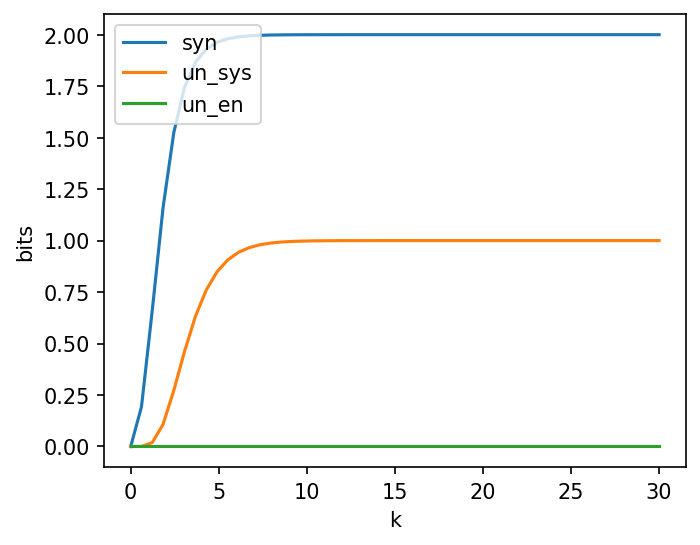

In [5]:
syn_list = []
un_sys_list = []
un_en_list = []
k_axis = np.linspace(0, 30, 50)
for k in k_axis:
    
    tpm_v = tpm_syn(k=k, w=1)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2) 
    syn_list.append(syn)
    un_sys_list.append(un_sys)
    un_en_list.append(un_en)
    
plt.figure(figsize=(5,4),dpi=150)
plt.plot(k_axis, syn_list, label='syn')
plt.plot(k_axis, un_sys_list, label="un_sys")
plt.plot(k_axis, un_en_list, label="un_en")
plt.xlabel('k')
plt.ylabel('bits')
plt.legend()

# 引入环境脉冲，呈现系统状态的切换

In [83]:
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
def tpm_series2(tpm, init_state, steps):
    init_num = int(init_state, 2)
    serie = [init_num]
    serie_str = [init_state]
    for t in range(steps):
        num = serie[t]
        probabilities = tpm[num, :]
        sample = np.random.choice(range(len(probabilities)), p=probabilities)
        serie.append(sample)
        serie_str.append(decimal_to_binary(sample, min_length=int(np.log2(len(probabilities)))))
    return serie, serie_str

def serie_plot2(w, k, en_series, name='', leg=False, figure_show=True):
    series_ls = []
    tpm_v = tpm_syn(k=k, w=w)
    un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
    colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500', "#0000FF", "#0000E0", "#1E90FF", "#87CEEB"]
    strs = [decimal_to_binary(i, min_length=3) for i in range(8)] 
    for indx, init_state in enumerate(strs[:2]):
        long_serie = []
        
        for en_list in en_series:
            en_state = en_list[0]
            steps = len(en_list)
            serie, serie_str = tpm_series2(tpm_dic[en_state], init_state, steps)
            init_state = serie_str[-1]
            long_serie += serie[:-1]
        series_ls.append(long_serie)
        
    if figure_show:
        fig, ax = plt.subplots(figsize=(10,4), dpi=150)
        for indx, long_serie in enumerate(series_ls):
            #ax.scatter(range(len(long_serie)), np.ones(len(long_serie))*indx, color='#2A69B3', alpha=1/8, s=100)
            ax.scatter(range(len(long_serie)), long_serie, label='init_state:'+strs[indx], color=colors[indx], s=100)
        ax.set_xlabel('Time')
        ax.set_ylabel('System state')
        # 设置y轴的标签
        ax.set_yticks(range(8))
        ax.set_yticklabels(strs)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        if leg:
            plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
        plt.title(name + '_syn=' + str(round(syn,4)))
        # 显示图形
        plt.show()
        
    return un_sys, un_en, syn, series_ls

In [84]:
#label='init_state:'+strs[indx]

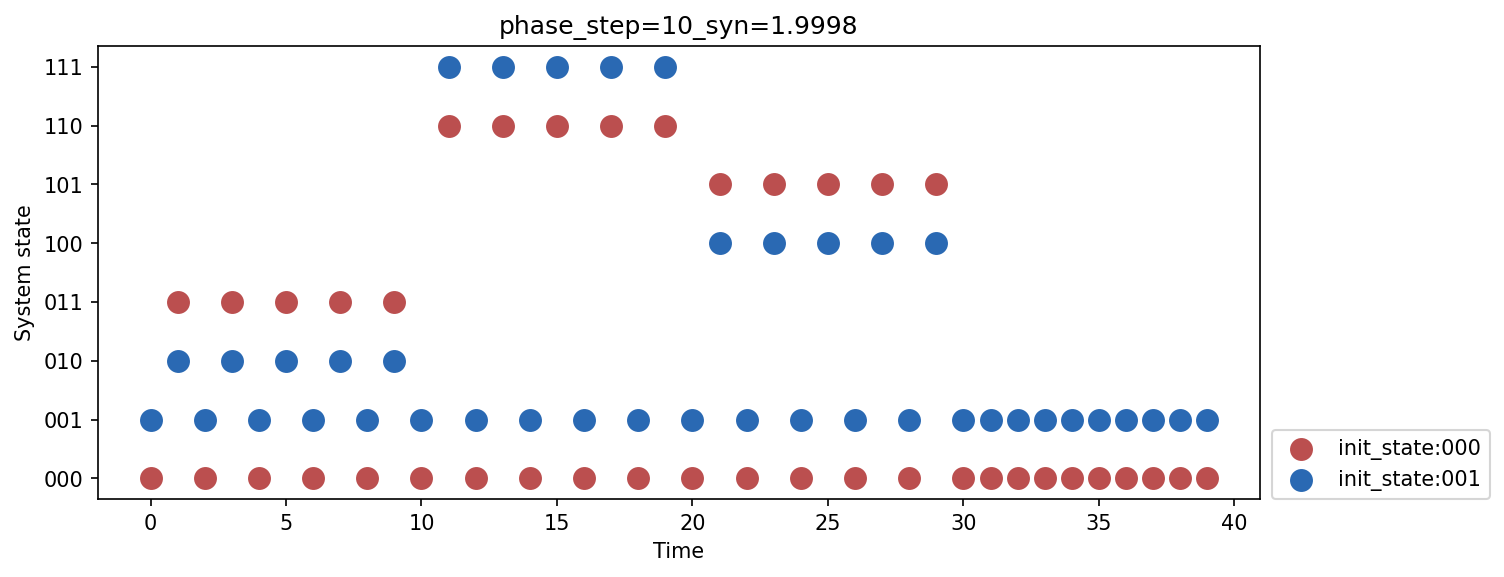

In [85]:
seed = 42
np.random.seed(seed)
w = 1
k = 10
n = 10
en_series = [['00' for _ in range(n)], ['01' for _ in range(n)], ['10' for _ in range(n)], ['11' for _ in range(n)]]
un_sys, un_en, syn, series_ls = serie_plot2(w, k, en_series, name='phase_step='+str(n), leg=True, figure_show=True)

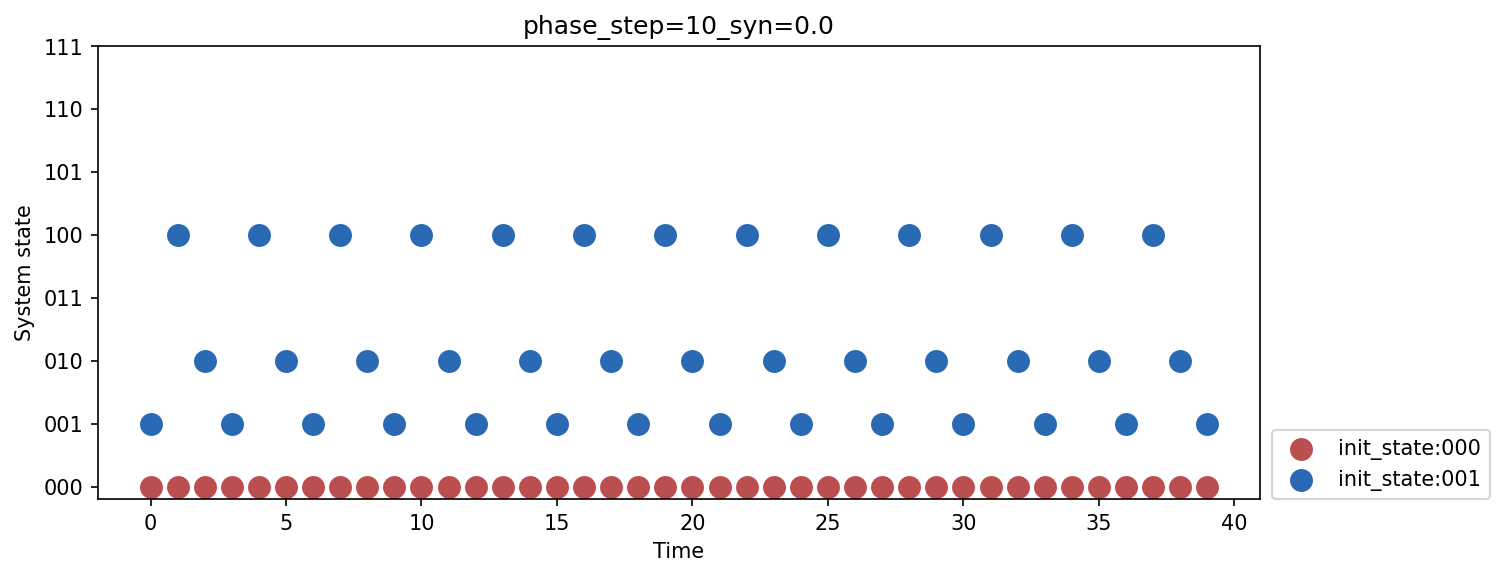

In [86]:
seed = 42
np.random.seed(seed)
w = 0
k = 10
n = 10
en_series = [['00' for _ in range(n)], ['01' for _ in range(n)], ['10' for _ in range(n)], ['11' for _ in range(n)]]
un_sys, un_en, syn, series_ls = serie_plot2(w, k, en_series, name='phase_step='+str(n), leg=True, figure_show=True)

# 随着环境状态差异的增大，系统稳态之间距离的变化

In [35]:
k_axis = [0.01, 0.1, 0.2, 0.5, 1, 5]#np.linspace(0, 1, n)
n = len(k_axis)
seeds = 5
steps = 10
dis_k = np.zeros([n, steps])
dis_std = np.zeros([n, steps])
syn_ls = []
for m,k in enumerate(k_axis):
    dis_arr = np.zeros([seeds, steps])
    for seed in range(seeds):
        for step in range(0, steps):
            _,_, syn, series_ls = serie_plot(bnet, w=1, k=k, steps=step, seed=seed, name='', leg=False, syn_inter=True)
            dis_arr[seed, step] = dis_mean(series_ls)
    syn_ls.append(syn)
    dis_k[m, :] = dis_arr.mean(axis=0)
    dis_std[m, :] = dis_arr.std(axis=0)

Text(0, 0.5, 'Mean Distance')

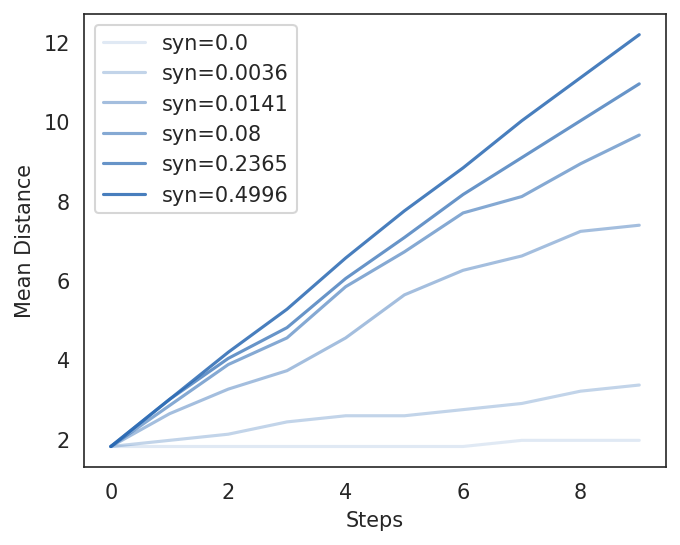

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500', '#8A2BE2', '#DAA520', '#FF4500']
# 设置Seaborn风格为whitegrid
sns.set_style("white")

plt.figure(figsize=(5,4), dpi=150)
for i in range(n):
    plt.plot(dis_k[i, :], label='syn='+str(np.round(syn_ls[i], 4)), color='#2A69B3', alpha=(i+1)/7)
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Mean Distance')

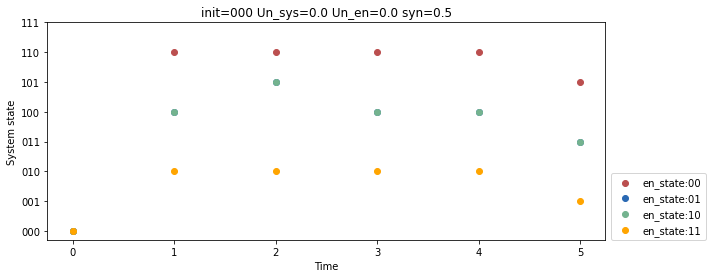

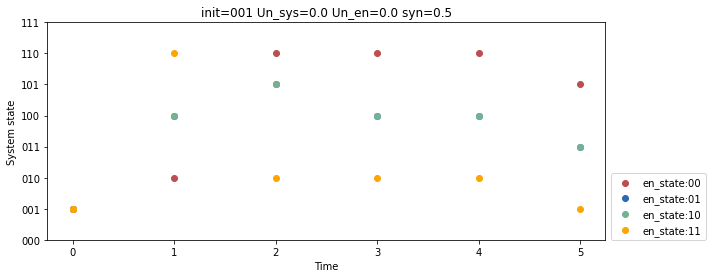

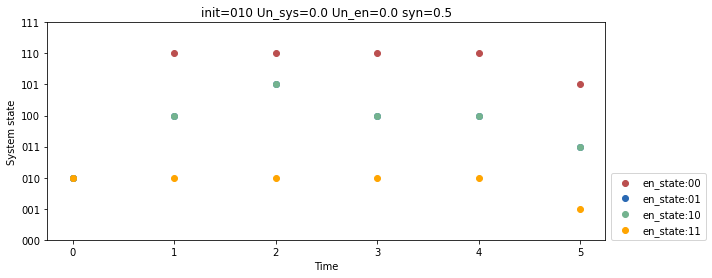

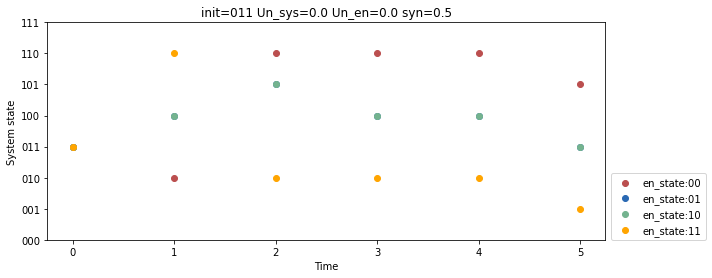

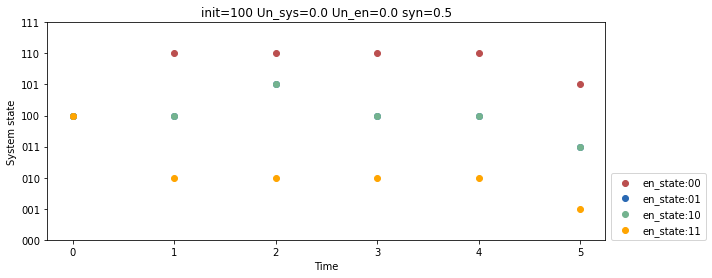

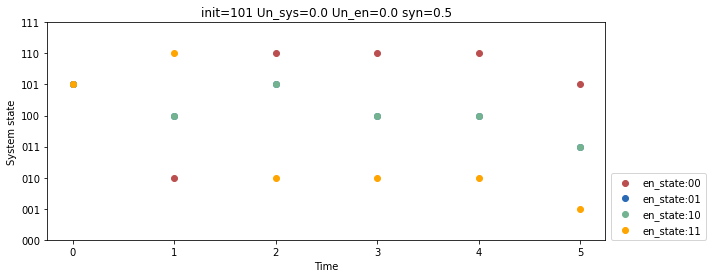

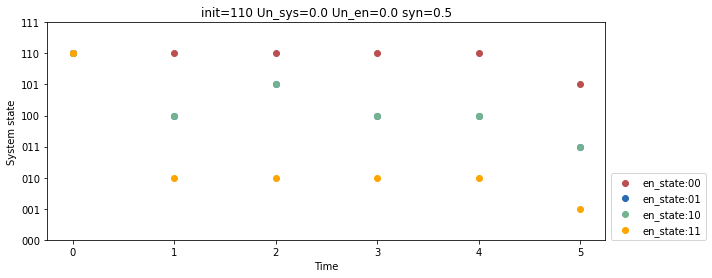

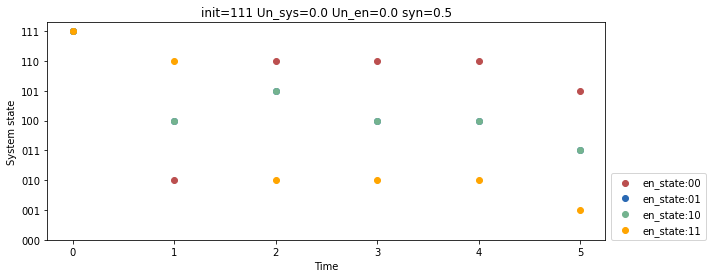

In [83]:
seeds = 1
steps = 5
tpm_v = tpm_syn(k=30, w=1)
name = 'k=0.2_w=1'
un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
for init_state in strs:
    fig, ax = plt.subplots(figsize=(10,4))
    for indx,en in enumerate(["00", "01", "10", "11"]):
        #en = '10'
        #indx = 2
        en_state = en
        for seed in range(seeds):
            seed = seed 
            serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

            # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
            ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

    # 设置轴标签
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')

    # 设置y轴的标签
    ax.set_yticks(range(8))
    ax.set_yticklabels(strs)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
    plt.title('init=' + init_state + ' Un_sys=' + str(round(un_sys,4)) + ' Un_en=' + str(round(un_en,4)) +' syn=' + str(round(syn,4)))
    # 显示图形
    plt.show()

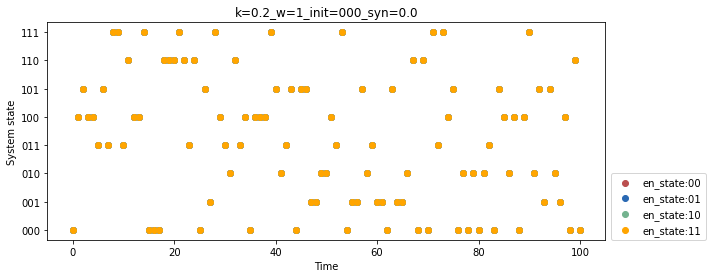

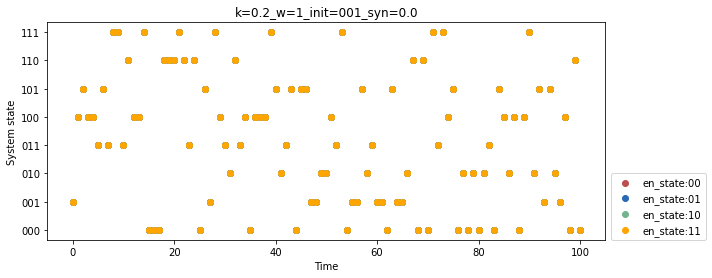

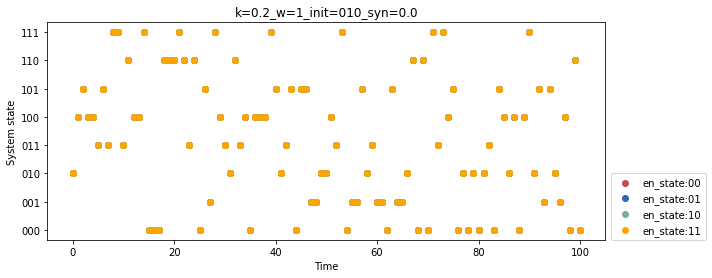

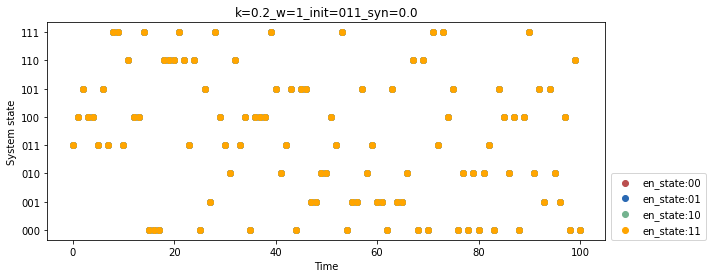

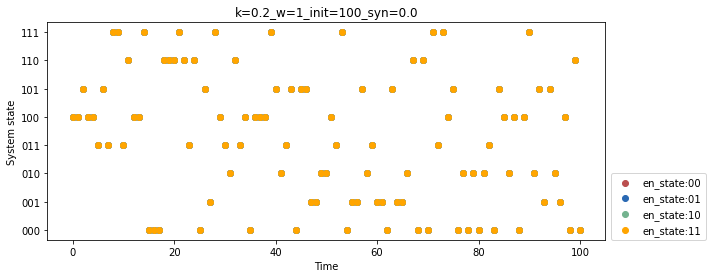

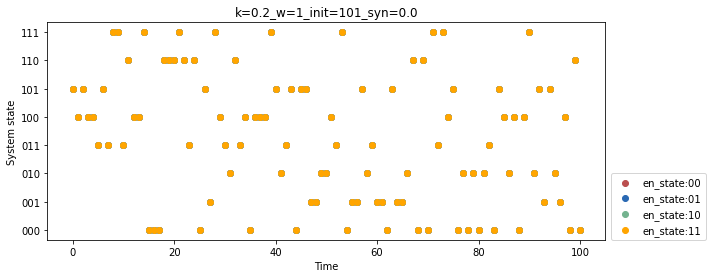

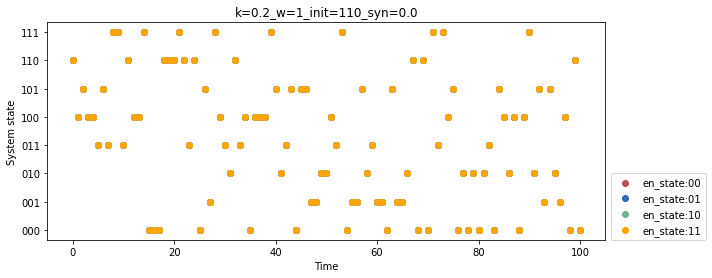

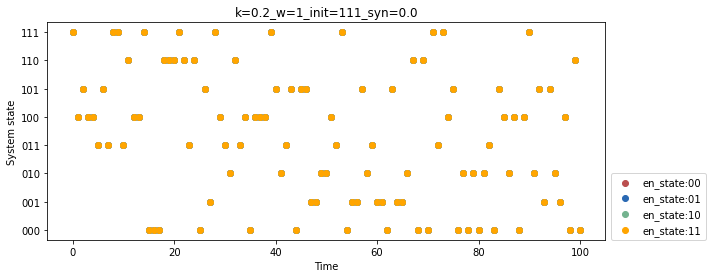

In [72]:
seeds = 1
steps = 100
tpm_v = tpm_syn(k=0, w=1)
name = 'k=0.2_w=1'
un_sys, un_en, syn, tpm_dic = iit_tpm_cal(tpm_v, mech_size=3, en_size=2)   
colors = ["#BB4F4F", '#2A69B3', '#74B38F', '#FFA500']
strs = [decimal_to_binary(i, min_length=3) for i in range(8)]
for init_state in strs:
    fig, ax = plt.subplots(figsize=(10,4))
    for indx,en in enumerate(["00", "01", "10", "11"]):
        en_state = en
        for seed in range(seeds):
            serie, serie_str = tpm_series(tpm_dic[en_state], init_state, steps, seed)

            # 由于二进制字符串不能直接作为y轴的值，我们可以使用它们的索引作为y轴的值
            ax.scatter(range(steps+1), serie, label='en_state:'+en_state, color=colors[indx])

    # 设置轴标签
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')

    # 设置y轴的标签
    ax.set_yticks(range(8))
    ax.set_yticklabels(strs)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=[1.01, 0])
    plt.title(name + '_init=' + init_state + '_syn=' + str(round(syn,4)))
    # 显示图形
    plt.show()